In [1]:
import random
import numpy as np

import torch
import matplotlib.pyplot as plt
%matplotlib inline

from torchvision.transforms import v2 as transforms_v2
from torchvision.io import decode_image

import hydra
from omegaconf import DictConfig, OmegaConf
from hydra import initialize, compose

import dr_gen.utils.data as du
import dr_gen.utils.run as ru
import dr_gen.utils.viz as vu

%load_ext autoreload
%autoreload 2

### Setup Config & Helpers

In [2]:
root_path = "/Users/daniellerothermel/drotherm"
repo_path = f"{root_path}/repos/dr_gen/"

In [3]:
with initialize(config_path=f"../scripts/conf/", version_base=None):
    cfg = compose(
        config_name="config.yaml",
        overrides=[
            f"paths.root={root_path}",
            f"data.num_workers=4",
        ],
    )

In [4]:
print(OmegaConf.to_yaml(OmegaConf.to_container(cfg, resolve=True)))

paths:
  root: /Users/daniellerothermel/drotherm
  data: /Users/daniellerothermel/drotherm/data/dr_gen
  logs: /Users/daniellerothermel/drotherm/logs/dr_gen
  dataset_cache_root: /Users/daniellerothermel/drotherm/data/dr_gen/cifar10/
data:
  name: cifar10
  num_workers: 4
  cache_dataset: true
  download: true
  transform:
    train:
      normalize: true
      random_crop: true
      random_horizontal_flip: true
      color_jitter: true
      normalize_mean:
      - 0.4914
      - 0.4822
      - 0.4465
      normalize_std:
      - 0.2023
      - 0.1994
      - 0.201
      crop_size: 32
      crop_padding: 4
      random_horizontal_flip_prob: 0.5
      jitter_brightness: 0.247
    eval:
      normalize: true
      random_crop: false
      random_horizontal_flip: false
      color_jitter: false
      normalize_mean:
      - 0.4914
      - 0.4822
      - 0.4465
      normalize_std:
      - 0.2023
      - 0.1994
      - 0.201
      crop_size: null
      crop_padding: null
      random_hor

In [5]:
generator = ru.set_deterministic(cfg.seed)

### Test Out Dataloading

#### PIL images

In [28]:
# Test loading dataset with PIL images
cifar10_train_pil = du.get_dataset(
    cfg.data, cfg.paths, train=True, as_pil=True,
)
cifar10_train_pil

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: /Users/daniellerothermel/drotherm/data/dr_gen/cifar10/
    Split: Train

In [29]:
sample_pil = cifar10_train_pil[0]
sample_pil

(<PIL.Image.Image image mode=RGB size=32x32>, 6)

In [34]:
print(f"{type(sample_pil[0]) = }")

type(sample_pil[0]) = <class 'PIL.Image.Image'>


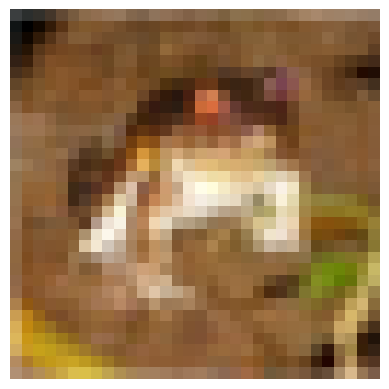

In [35]:
plt.imshow(sample_pil[0])
plt.axis("off")
plt.show()

#### TV Tensor Images

In [19]:
# Test loading dataset with tensors
cifar10_train_tvt = du.get_dataset(
    cfg.data, cfg.paths, train=True, as_pil=False,
)
cifar10_train_tvt

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Dataset CIFAR10
    Number of datapoints: 50000
    Root location: /Users/daniellerothermel/drotherm/data/dr_gen/cifar10/
    Split: Train
    StandardTransform
Transform: Compose(
                 ToImage()
                 ToDtype(scale=True)
                 RandomCrop(size=(32, 32), padding=[4, 4, 4, 4], pad_if_needed=False, fill=0, padding_mode=constant)
                 RandomHorizontalFlip(p=0.5)
                 ColorJitter(brightness=(0.7529411764705882, 1.2470588235294118))
                 Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.201], inplace=False)
           )

In [20]:
sample_tvt = cifar10_train_tvt[0]
sample_tvt

(Image([[[ 0.1115,  0.3679,  0.3212,  ..., -1.2870, -2.0561, -1.8464],
         [-0.2381,  0.3912,  0.4844,  ..., -0.4013, -1.5434, -1.6599],
         [-0.8674, -0.6810, -0.4013,  ..., -0.0517, -1.0539, -1.2637],
         ...,
         [ 0.4378,  1.0904,  2.5141,  ...,  1.7430,  1.4866,  1.6964],
         [-2.4291, -2.4291, -2.4291,  ..., -2.4291, -2.4291, -2.4291],
         [-2.4291, -2.4291, -2.4291,  ..., -2.4291, -2.4291, -2.4291]],
 
        [[-0.6920, -0.4319, -0.4319,  ..., -1.7798, -2.2527, -1.8507],
         [-0.9522, -0.4083, -0.3610,  ..., -1.1413, -1.9453, -1.8271],
         [-1.4251, -1.3069, -1.0704,  ..., -0.8812, -1.6616, -1.6616],
         ...,
         [-0.2428,  0.3721,  1.9327,  ...,  0.9396,  0.6322,  0.9869],
         [-2.4183, -2.4183, -2.4183,  ..., -2.4183, -2.4183, -2.4183],
         [-2.4183, -2.4183, -2.4183,  ..., -2.4183, -2.4183, -2.4183]],
 
        [[-1.2361, -1.0485, -1.0485,  ..., -2.0337, -2.2214, -1.7288],
         [-1.4003, -1.0954, -1.0485,  ..., 

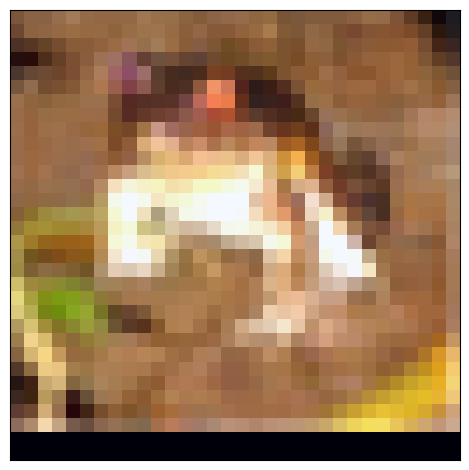

In [24]:
vu.plot([sample_tvt[0]])

### Test out Dataloader

In [25]:
cifar10_train = du.get_dataset(
    cfg.data, cfg.paths, train=True, as_pil=False,
)

In [31]:
cifar10_eval = du.get_dataset(
    cfg.data, cfg.paths, train=False, as_pil=False,
)

In [30]:
cifar10_dl_train = du.get_dataloader(cfg, cifar10_train, generator, train=True)

In [35]:
cifar10_dl_eval = du.get_dataloader(cfg, cifar10_eval, generator, train=False)

In [6]:
#cft = du.load_data(cfg, generator)
train_ds, val_ds = du.setup_train_val_datasets(cfg, generator)

Compose(    [ToImage(), ToDtype(scale=True), RandomCrop(size=(32, 32), padding=[4, 4, 4, 4], pad_if_needed=False, fill=0, padding_mode=constant), RandomHorizontalFlip(p=0.5), ColorJitter(brightness=(0.753, 1.2469999999999999)), Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.201], inplace=False)])
Compose(    [ToImage(), ToDtype(scale=True), Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.201], inplace=False)])


In [7]:
len(train_ds), len(val_ds)

(40000, 10000)

In [8]:
train_ds[0]

(<PIL.Image.Image image mode=RGB size=32x32>, 6)

In [9]:
val_ds[0]

(<PIL.Image.Image image mode=RGB size=32x32>, 1)

In [10]:
train_dl, val_dl = du.setup_train_val_dataloaders(cfg, generator)

Compose(    [ToImage(), ToDtype(scale=True), RandomCrop(size=(32, 32), padding=[4, 4, 4, 4], pad_if_needed=False, fill=0, padding_mode=constant), RandomHorizontalFlip(p=0.5), ColorJitter(brightness=(0.753, 1.2469999999999999)), Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.201], inplace=False)])
Compose(    [ToImage(), ToDtype(scale=True), Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.201], inplace=False)])


In [11]:
train_features, train_labels = next(iter(val_dl))
print(f"Label: {train_labels[0]}, Batch Shape: {train_features.shape}")
vu.plot([train_features[0].squeeze()])

TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/Users/daniellerothermel/drotherm/repos/dr_gen/.venv/lib/python3.12/site-packages/torch/utils/data/_utils/worker.py", line 349, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "/Users/daniellerothermel/drotherm/repos/dr_gen/.venv/lib/python3.12/site-packages/torch/utils/data/_utils/fetch.py", line 55, in fetch
    return self.collate_fn(data)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/Users/daniellerothermel/drotherm/repos/dr_gen/.venv/lib/python3.12/site-packages/torch/utils/data/_utils/collate.py", line 398, in default_collate
    return collate(batch, collate_fn_map=default_collate_fn_map)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/daniellerothermel/drotherm/repos/dr_gen/.venv/lib/python3.12/site-packages/torch/utils/data/_utils/collate.py", line 212, in collate
    collate(samples, collate_fn_map=collate_fn_map)
  File "/Users/daniellerothermel/drotherm/repos/dr_gen/.venv/lib/python3.12/site-packages/torch/utils/data/_utils/collate.py", line 240, in collate
    raise TypeError(default_collate_err_msg_format.format(elem_type))
TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'PIL.Image.Image'>


In [62]:
train_features, train_labels = next(iter(train_dl))
print(f"Label: {train_labels[0]}, Batch Shape: {train_features.shape}")
vu.plot([train_features[0].squeeze()])

TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/Users/daniellerothermel/drotherm/repos/dr_gen/.venv/lib/python3.12/site-packages/torch/utils/data/_utils/worker.py", line 349, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "/Users/daniellerothermel/drotherm/repos/dr_gen/.venv/lib/python3.12/site-packages/torch/utils/data/_utils/fetch.py", line 50, in fetch
    data = self.dataset.__getitems__(possibly_batched_index)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/daniellerothermel/drotherm/repos/dr_gen/.venv/lib/python3.12/site-packages/torch/utils/data/dataset.py", line 420, in __getitems__
    return [self.dataset[self.indices[idx]] for idx in indices]
            ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^
  File "/Users/daniellerothermel/drotherm/repos/dr_gen/.venv/lib/python3.12/site-packages/torchvision/datasets/cifar.py", line 119, in __getitem__
    img = self.transform(img)
          ^^^^^^^^^^^^^^^^^^^
  File "/Users/daniellerothermel/drotherm/repos/dr_gen/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py", line 1739, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/daniellerothermel/drotherm/repos/dr_gen/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py", line 1750, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/daniellerothermel/drotherm/repos/dr_gen/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/_container.py", line 51, in forward
    outputs = transform(*inputs)
              ^^^^^^^^^^^^^^^^^^
TypeError: 'list' object is not callable


In [ ]:
train_features, train_labels = next(iter(val_dl))
print(f"Label: {train_labels[0]}, Batch Shape: {train_features.shape}")
vu.plot([train_features[0].squeeze()])

Label: 3, Batch Shape: torch.Size([5, 3, 32, 32])


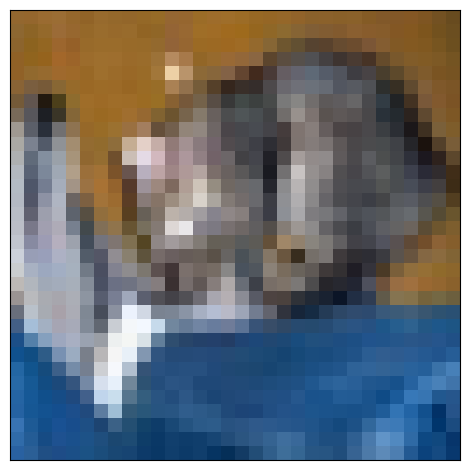

In [40]:
eval_features, eval_labels = next(iter(cifar10_dl_eval))
print(f"Label: {eval_labels[0]}, Batch Shape: {eval_features.shape}")
vu.plot([eval_features[0].squeeze()])